In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate, Flatten
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
file_path = '/content/drive/MyDrive/continuous dataset.csv'
Train_data = pd.read_csv(file_path)

In [43]:
Train_data['datetime'] = pd.to_datetime(Train_data['datetime'])

In [44]:
Train_data['datetime'].min(), Train_data['datetime'].max()

(Timestamp('2015-01-03 01:00:00'), Timestamp('2020-06-27 00:00:00'))

In [45]:
Train_data['datetime'] = pd.to_datetime(Train_data['datetime'])
Train_data.set_index('datetime', inplace=True)

In [38]:
Train_data.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [5]:
# Resample the data to hourly mean based on 'nat_demand'
data_resampled = Train_data.resample('H').mean().reset_index()

# Select the features for DNN and LSTM, and label
dnn_features = data_resampled[['QV2M_toc', 'TQL_toc', 'W2M_toc', 'QV2M_san', 'TQL_san', 'W2M_san', 'QV2M_dav', 'TQL_dav', 'W2M_dav', 'datetime']]
lstm_features = data_resampled[['QV2M_toc', 'TQL_toc', 'W2M_toc', 'QV2M_san', 'TQL_san', 'W2M_san', 'QV2M_dav', 'TQL_dav', 'W2M_dav','T2M_toc', 'T2M_san', 'T2M_dav', 'datetime']]
labels = data_resampled['nat_demand']

# Convert datetime to numerical values (e.g., timestamp)
dnn_features['datetime'] = pd.to_datetime(dnn_features['datetime']).astype(int) / 10**9
lstm_features['datetime'] = pd.to_datetime(lstm_features['datetime']).astype(int) / 10**9

# Handle missing values
dnn_features = dnn_features.fillna(method='ffill')
lstm_features = lstm_features.fillna(method='ffill')


<ipython-input-5-9f22e6ad5f88>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = Train_data.resample('H').mean().reset_index()
<ipython-input-5-9f22e6ad5f88>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dnn_features['datetime'] = pd.to_datetime(dnn_features['datetime']).astype(int) / 10**9
<ipython-input-5-9f22e6ad5f88>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_features['datetime'] = pd.to_datetime(lstm_features['datetim

In [6]:
scaler_dnn = StandardScaler()
dnn_features_scaled = scaler_dnn.fit_transform(dnn_features)

scaler_lstm = StandardScaler()
lstm_features_scaled = scaler_lstm.fit_transform(lstm_features)

In [7]:
import joblib

# After fitting your scalers
joblib.dump(scaler_dnn, "scaler_dnn.pkl")
joblib.dump(scaler_lstm, "scaler_lstm.pkl")


['scaler_lstm.pkl']

In [8]:
X_dnn = dnn_features_scaled
X_lstm = lstm_features_scaled.reshape(lstm_features_scaled.shape[0], 1, lstm_features_scaled.shape[1])
y = labels.values

# Split the data
X_dnn_train, X_dnn_test, X_lstm_train, X_lstm_test, y_train, y_test = train_test_split(X_dnn, X_lstm, y, test_size=0.3, random_state=42)


In [9]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


117/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1434881.0000 - mae: 1182.3938 - mse: 1434881.0000Epoch 1 - RMSE: 1190.9694
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1434764.1250 - mae: 1182.3551 - mse: 1434764.1250 - val_loss: 1418053.1250 - val_mae: 1175.3396 - val_mse: 1418053.1250 - learning_rate: 0.0010
Epoch 2/100
122/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1429094.6250 - mae: 1180.1604 - mse: 1429094.6250Epoch 2 - RMSE: 1187.3073
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 1428797.2500 - mae: 1180.0393 - mse: 1428797.2500 - val_loss: 1408738.0000 - val_mae: 1171.6155 - val_mse: 1408738.0000 - learning_rate: 0.0010
Epoch 3/100
122/132 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1415492.5000 - mae: 1174.4753 - mse: 1415492.5000Epoch 3 - RMSE: 1181.3526
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1415170.3750 - mae: 1174.3549 - mse: 1415170.3750 - val_loss: 1393710.6250 - val_mae: 1165.5411 - val_mse: 1393710.6250 - learning_rate: 0.0010
Epoch 4/100
115/132 ━

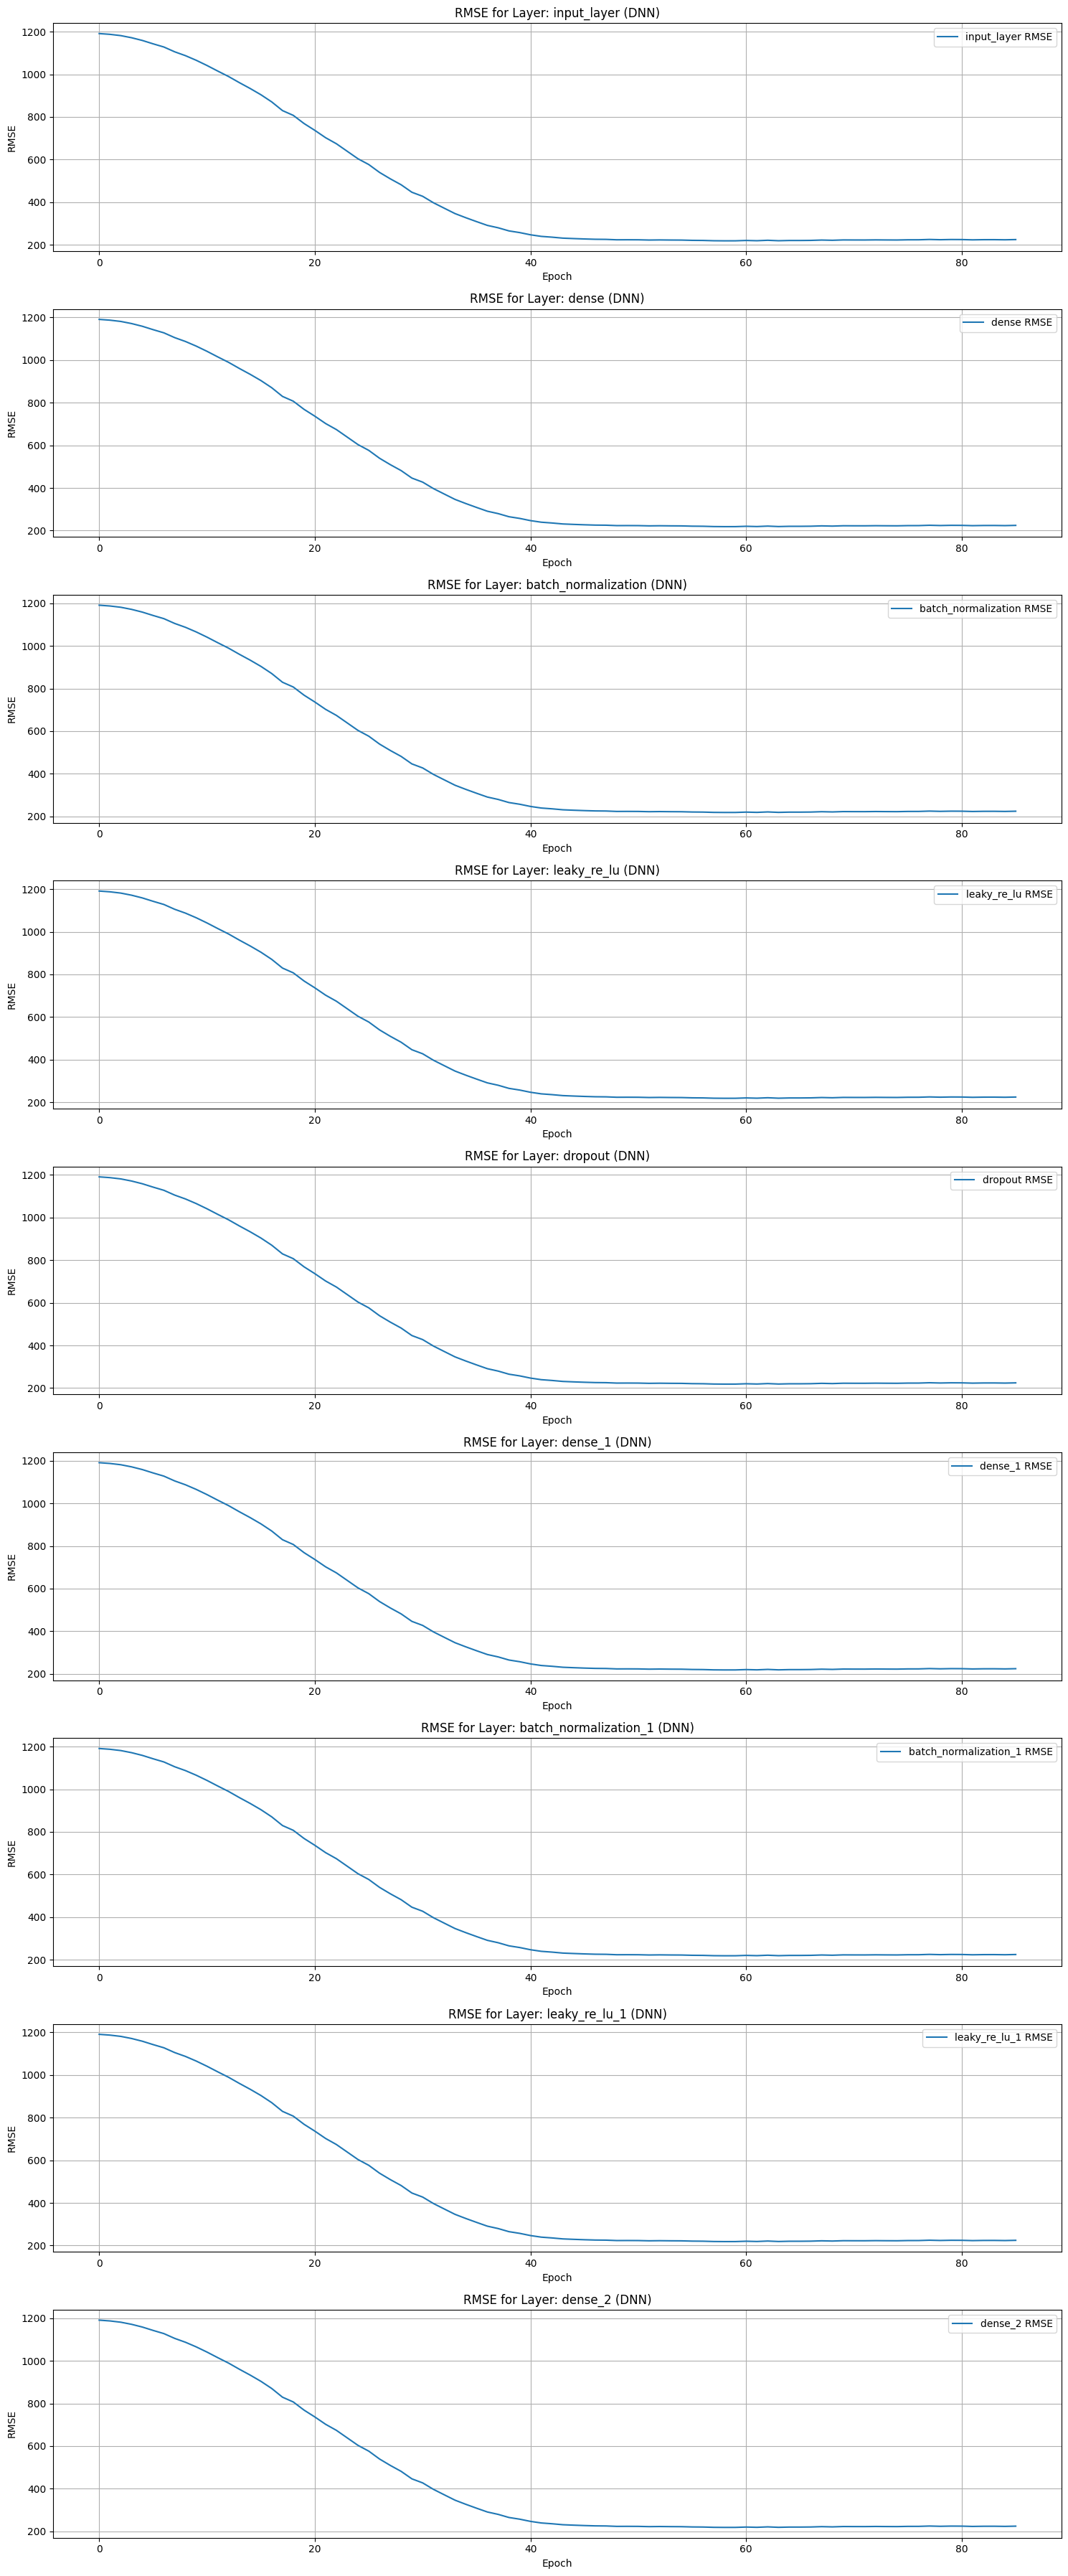

451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 24093.1523 - mae: 124.9944 - mse: 24093.1367
DNN - Root Mean Squared Error (RMSE): 155.42771757516417
DNN - Mean Absolute Error (MAE): 125.25269317626953
DNN - Mean Squared Error (MSE): 24157.775390625


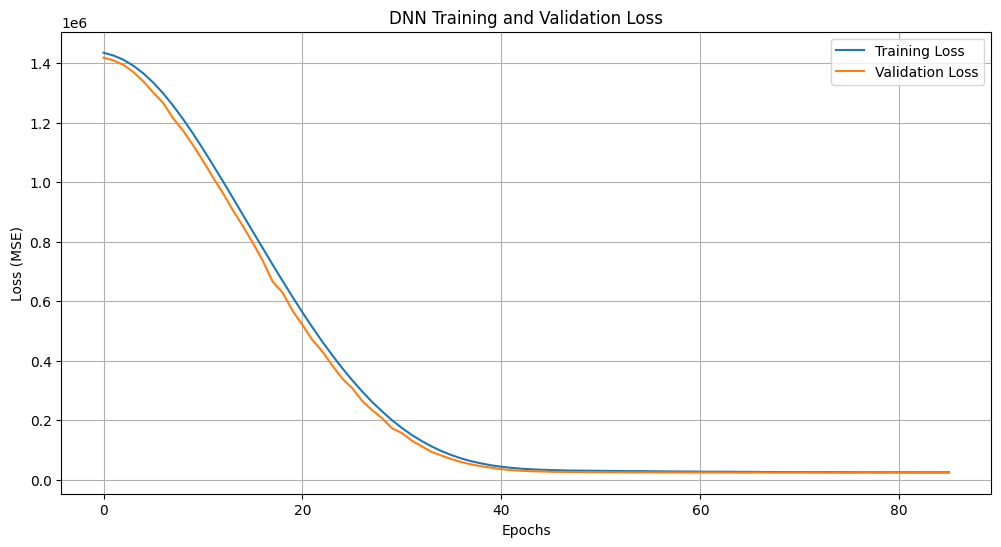

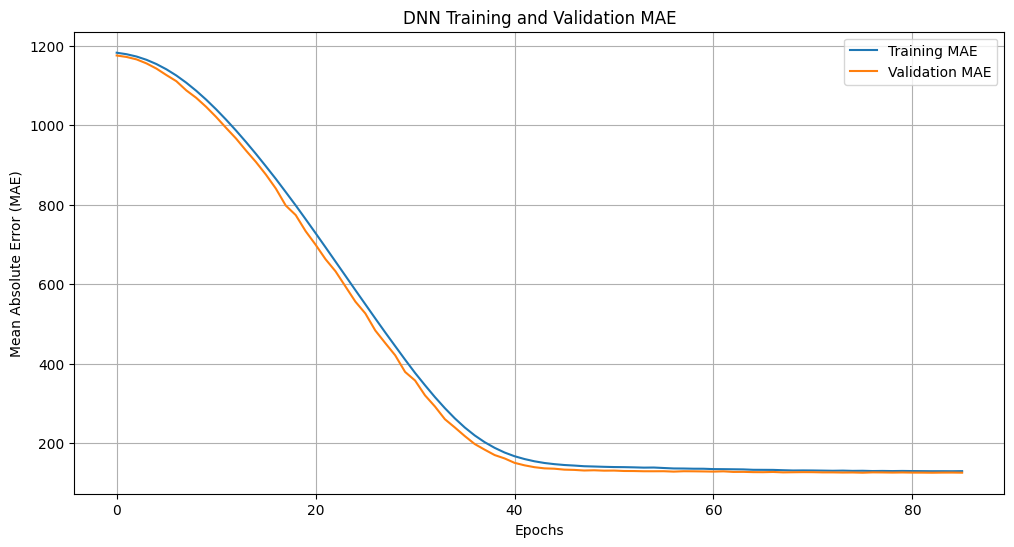

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
import matplotlib.pyplot as plt

# RMSE Callback for DNN
class RMSECallback(Callback):
    def __init__(self, validation_data):
        super(RMSECallback, self).__init__()
        self.validation_data = validation_data
        self.layer_rmse = {}

    def on_epoch_end(self, epoch, logs=None):
        # Unpack validation data for prediction
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)

        # Compute RMSE
        rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))

        # Store RMSE for each layer
        for layer in self.model.layers:
            if layer.name not in self.layer_rmse:
                self.layer_rmse[layer.name] = []
            self.layer_rmse[layer.name].append(rmse)

        print(f"Epoch {epoch + 1} - RMSE: {rmse:.4f}")

    def get_layer_rmse(self):
        return self.layer_rmse


# Define model inputs for DNN
input_dnn = Input(shape=(X_dnn_train.shape[1],))

# DNN architecture
dnn = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(input_dnn)
dnn = BatchNormalization()(dnn)
dnn = tf.keras.layers.LeakyReLU(alpha=0.1)(dnn)
dnn = Dropout(0.2)(dnn)
dnn = Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(dnn)
dnn = BatchNormalization()(dnn)
dnn = tf.keras.layers.LeakyReLU(alpha=0.1)(dnn)
output_layer_dnn = Dense(1)(dnn)

# Create and compile the DNN model
model_dnn = Model(inputs=input_dnn, outputs=output_layer_dnn)
model_dnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])

# Callbacks for DNN
early_stopping_dnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_dnn = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
rmse_callback_dnn = RMSECallback(validation_data=(X_dnn_test, y_test))
model_checkpoint_dnn = ModelCheckpoint('best_dnn_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Fit the DNN model
history_dnn = model_dnn.fit(
    X_dnn_train, y_train,
    validation_data=(X_dnn_test, y_test),
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping_dnn, model_checkpoint_dnn, reduce_lr_dnn, rmse_callback_dnn]
)

# After training, retrieve layer RMSE values for DNN
layer_rmse_dnn = rmse_callback_dnn.get_layer_rmse()

# Plot RMSE for each layer for DNN
plt.figure(figsize=(15, len(layer_rmse_dnn) * 4))
for i, (layer_name, rmse_values) in enumerate(layer_rmse_dnn.items()):
    plt.subplot(len(layer_rmse_dnn), 1, i + 1)
    plt.plot(rmse_values, label=f'{layer_name} RMSE')
    plt.title(f'RMSE for Layer: {layer_name} (DNN)')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the DNN model
loss_dnn, mae_dnn, mse_dnn = model_dnn.evaluate(X_dnn_test, y_test, verbose=1)
rmse_dnn = np.sqrt(mse_dnn)
print(f'DNN - Root Mean Squared Error (RMSE): {rmse_dnn}')
print(f'DNN - Mean Absolute Error (MAE): {mae_dnn}')
print(f'DNN - Mean Squared Error (MSE): {mse_dnn}')

# Plot Training and Validation Loss for DNN
plt.figure(figsize=(12, 6))
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('DNN Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation MAE for DNN
plt.figure(figsize=(12, 6))
plt.plot(history_dnn.history['mae'], label='Training MAE')
plt.plot(history_dnn.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('DNN Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()
model_dnn.save('dnn_model.keras')

Epoch 1/100
129/132 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1436215.6250 - mae: 1182.9318 - mse: 1436215.6250Epoch 1 - RMSE: 1188.4430
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 1436174.6250 - mae: 1182.9149 - mse: 1436174.6250 - val_loss: 1412396.7500 - val_mae: 1172.7819 - val_mse: 1412396.7500
Epoch 2/100
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1417312.5000 - mae: 1174.9882 - mse: 1417312.5000Epoch 2 - RMSE: 1171.3883
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 1417169.6250 - mae: 1174.9263 - mse: 1417169.6250 - val_loss: 1372150.5000 - val_mae: 1155.4960 - val_mse: 1372150.5000
Epoch 3/100
128/132 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1370245.7500 - mae: 1154.7233 - mse: 1370245.7500Epoch 3 - RMSE: 1143.0874
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 1369664.5000 - mae: 1154.4701 - mse: 1369664.5000 - val_loss: 1306648.6250 - val_mae: 1126.7957 - val_mse: 1306648.6250
Epoch 4/100
128/132 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1300925.5000 -

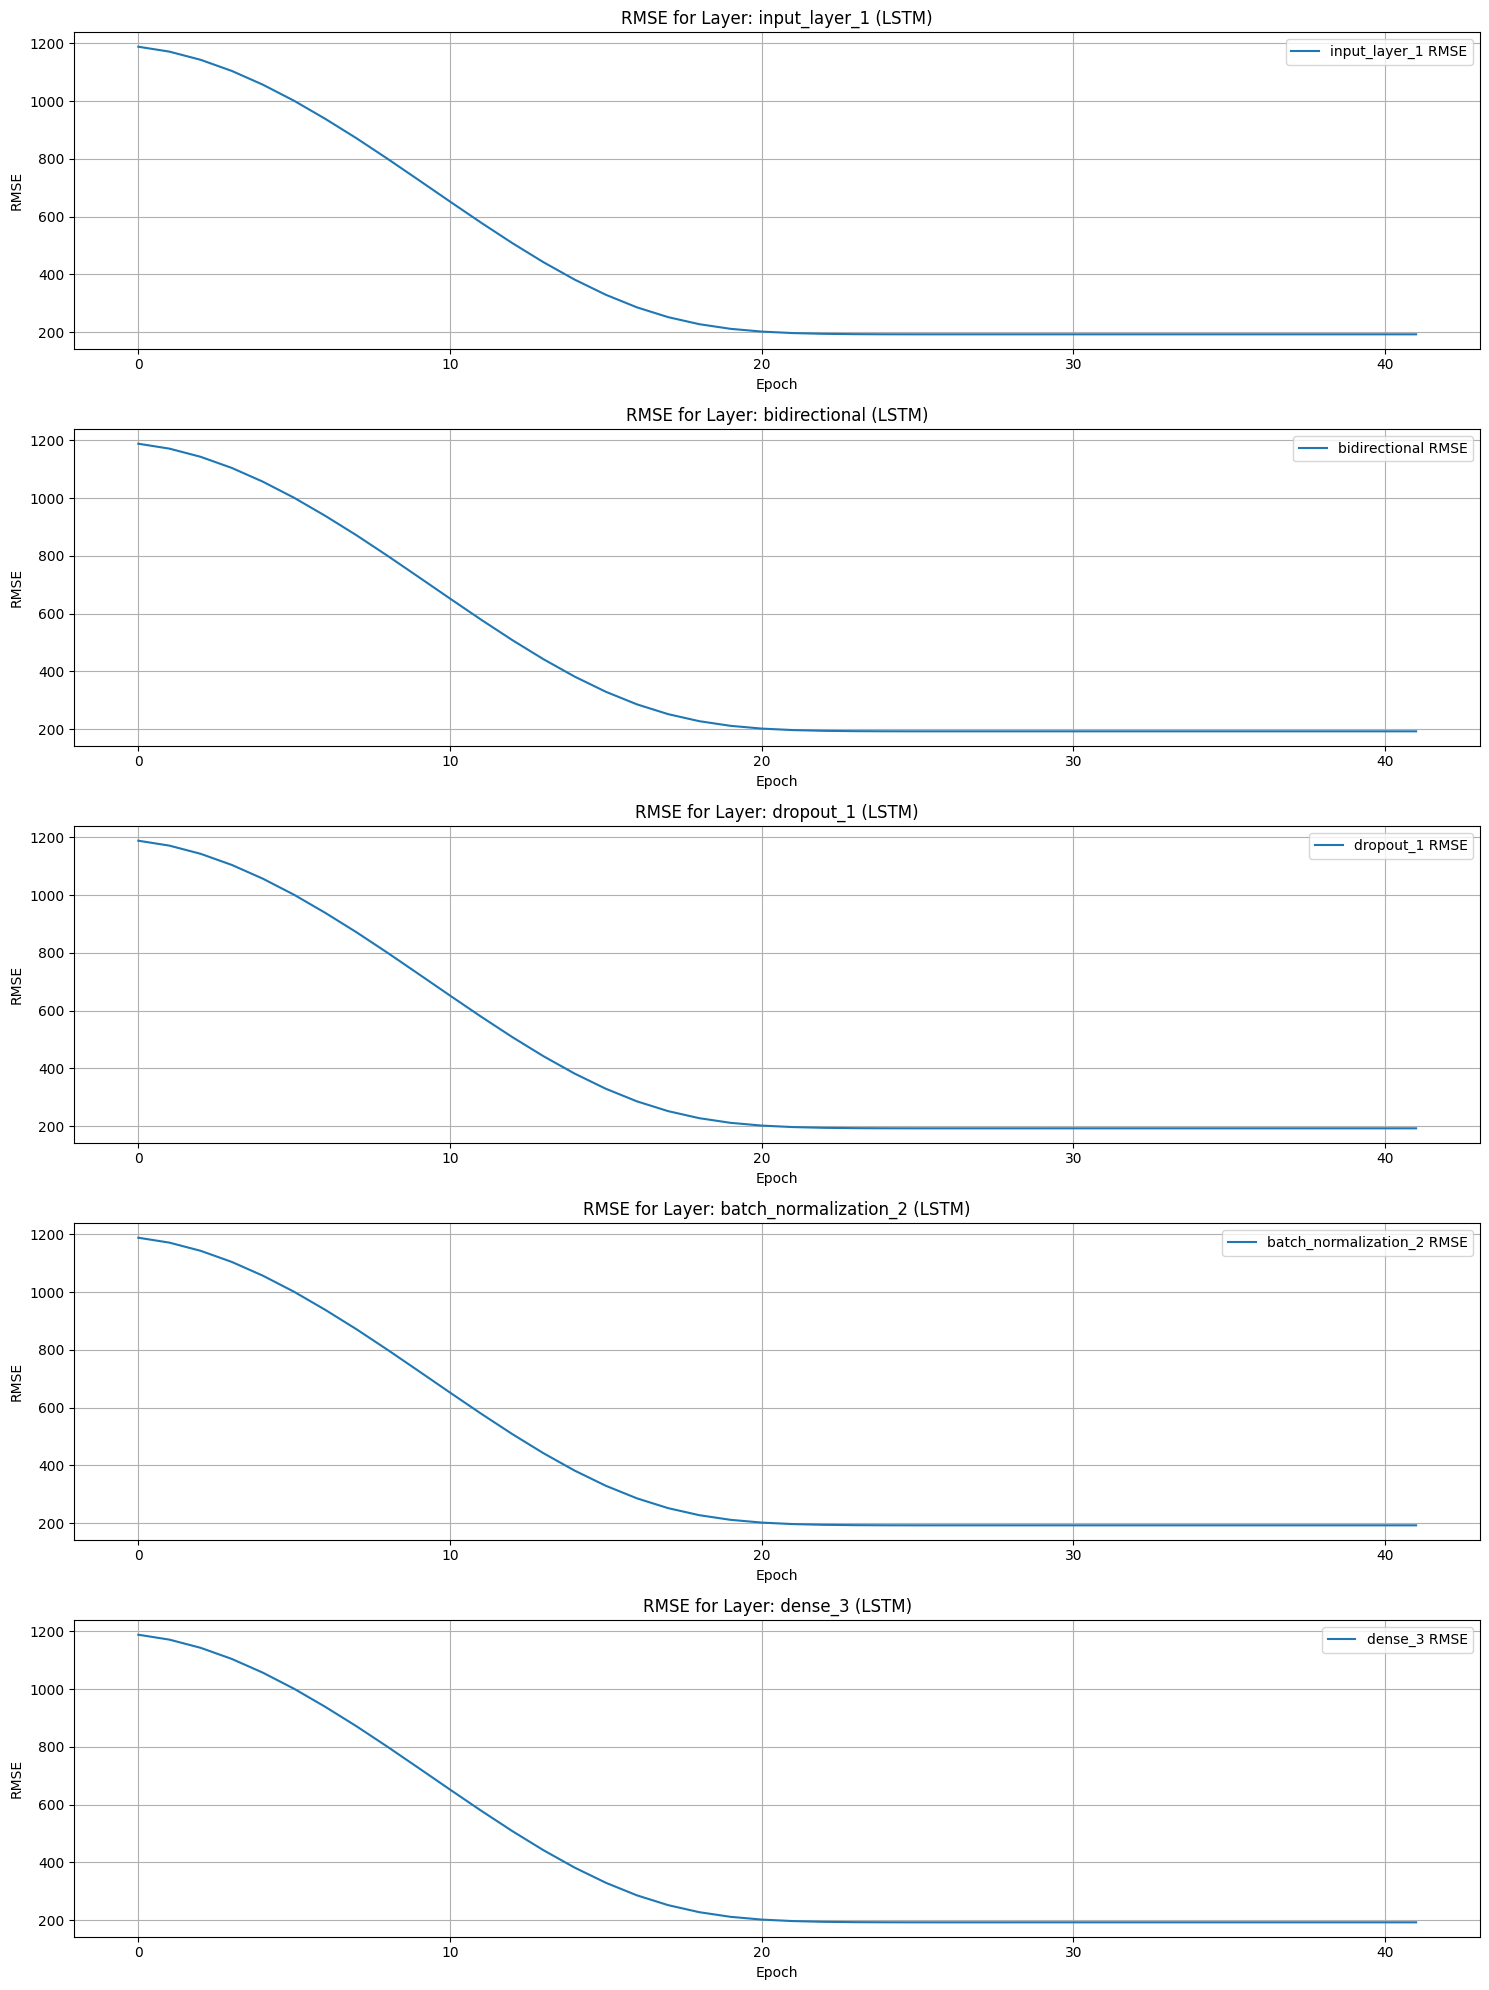

451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 36572.8477 - mae: 161.6454 - mse: 36572.8477
LSTM - Root Mean Squared Error (RMSE): 192.3017952821814
LSTM - Mean Absolute Error (MAE): 162.8985137939453
LSTM - Mean Squared Error (MSE): 36979.98046875


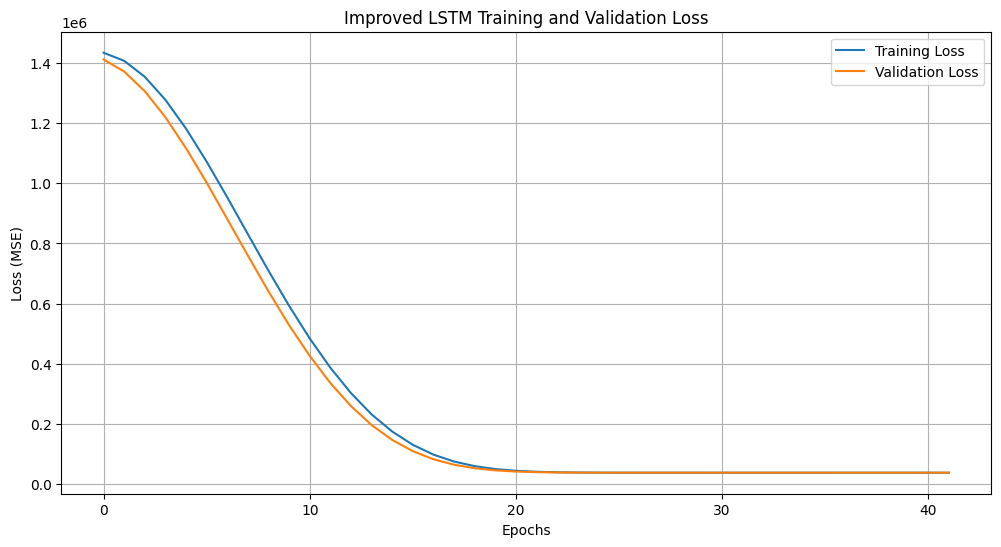

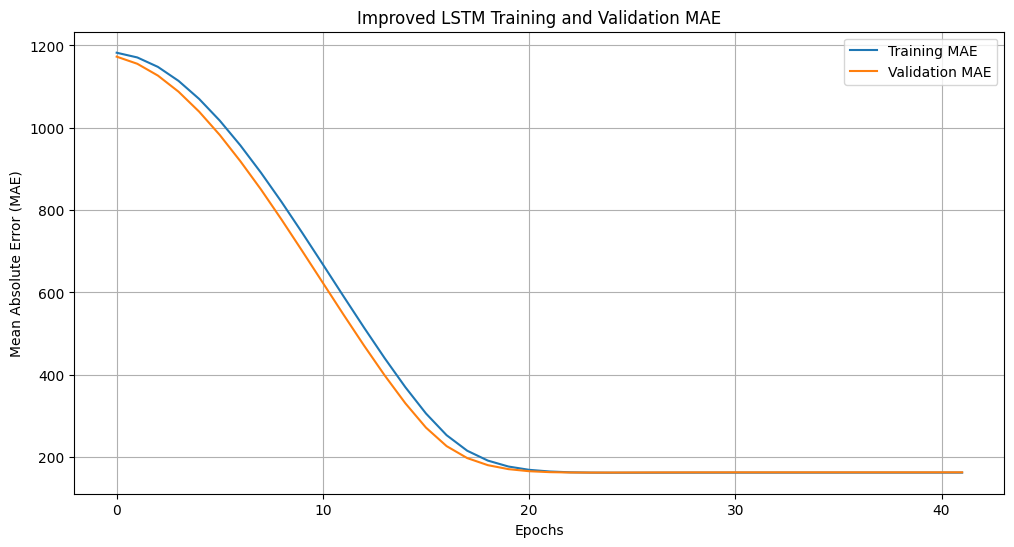

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
import matplotlib.pyplot as plt

# RMSE Callback for LSTM with learning rate adjustment
class RMSECallback(Callback):
    def __init__(self, validation_data, patience=3, factor=0.5, min_lr=1e-6):
        super(RMSECallback, self).__init__()
        self.validation_data = validation_data
        self.layer_rmse = {}
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.wait = 0
        self.best_rmse = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)
        rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))

        if rmse < self.best_rmse:
            self.best_rmse = rmse
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.model.optimizer.learning_rate * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(new_lr)
                print(f"\nEpoch {epoch + 1}: Reducing learning rate to {new_lr:.5f}")
                self.wait = 0

        for layer in self.model.layers:
            if layer.name not in self.layer_rmse:
                self.layer_rmse[layer.name] = []
            self.layer_rmse[layer.name].append(rmse)

        print(f"Epoch {epoch + 1} - RMSE: {rmse:.4f}")

    def get_layer_rmse(self):
        return self.layer_rmse

# Define model inputs for LSTM
input_lstm = Input(shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]))

# Improved LSTM architecture
lstm = Bidirectional(LSTM(64, return_sequences=True))(input_lstm)
lstm = Dropout(0.2)(lstm)
lstm = BatchNormalization()(lstm)
output_layer_lstm = Dense(1)(lstm)

# Create and compile the improved LSTM model
model_lstm = Model(inputs=input_lstm, outputs=output_layer_lstm)
model_lstm.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])

# Callbacks for LSTM
early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
rmse_callback_lstm = RMSECallback(validation_data=(X_lstm_test, y_test), patience=5, factor=0.5)
model_checkpoint_lstm = ModelCheckpoint('best_improved_lstm_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Fit the improved LSTM model
history_lstm = model_lstm.fit(
    X_lstm_train, y_train,
    validation_data=(X_lstm_test, y_test),
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping_lstm, model_checkpoint_lstm, rmse_callback_lstm]
)

# After training, retrieve layer RMSE values for LSTM
layer_rmse_lstm = rmse_callback_lstm.get_layer_rmse()

# Plot RMSE for each layer for LSTM
plt.figure(figsize=(15, len(layer_rmse_lstm) * 4))
for i, (layer_name, rmse_values) in enumerate(layer_rmse_lstm.items()):
    plt.subplot(len(layer_rmse_lstm), 1, i + 1)
    plt.plot(rmse_values, label=f'{layer_name} RMSE')
    plt.title(f'RMSE for Layer: {layer_name} (LSTM)')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the improved LSTM model
loss_lstm, mae_lstm, mse_lstm = model_lstm.evaluate(X_lstm_test, y_test, verbose=1)
rmse_lstm = np.sqrt(mse_lstm)
print(f'LSTM - Root Mean Squared Error (RMSE): {rmse_lstm}')
print(f'LSTM - Mean Absolute Error (MAE): {mae_lstm}')
print(f'LSTM - Mean Squared Error (MSE): {mse_lstm}')

# Plot Training and Validation Loss for LSTM
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Improved LSTM Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation MAE for LSTM
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['mae'], label='Training MAE')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Improved LSTM Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

# Save the improved LSTM model
model_lstm.save('lstm_model.keras')


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


126/132 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1432303.1250 - mae: 1181.3685 - mse: 1432303.1250Epoch 1 - RMSE: 1151.8641
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - loss: 1431259.6250 - mae: 1180.9310 - mse: 1431259.6250 - val_loss: 1325024.3750 - val_mae: 1135.6193 - val_mse: 1325024.3750 - learning_rate: 0.0010
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1247491.5000 - mae: 1100.6124 - mse: 1247491.5000Epoch 2 - RMSE: 982.9928
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 1246799.1250 - mae: 1100.2902 - mse: 1246799.1250 - val_loss: 958459.8750 - val_mae: 962.8477 - val_mse: 958459.8750 - learning_rate: 0.0010
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 828261.6875 - mae: 889.4827 - mse: 828261.6875Epoch 3 - RMSE: 707.4199
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 827351.0625 - mae: 888.9307 - mse: 827351.0625 - val_loss: 487352.7500 - val_mae: 676.3469 - val_mse: 487352.7500 - learning_rate: 0.0010
Epoch 4/100
127/132 ━━━━━━━━━━

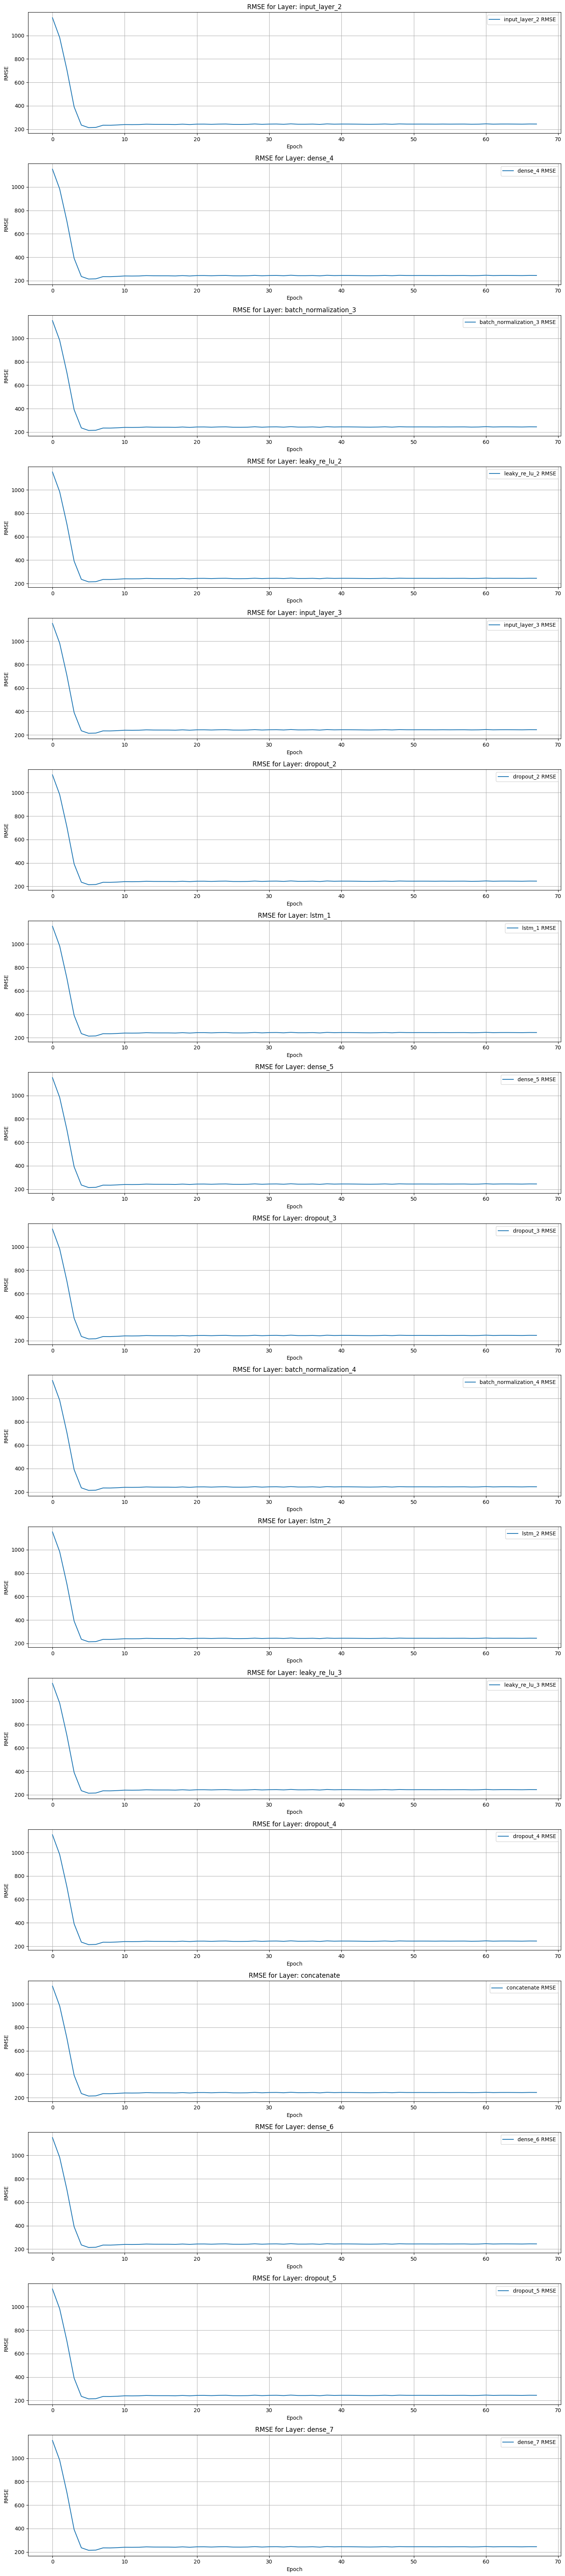

451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 13225.6436 - mae: 90.3996 - mse: 13225.6328
Root Mean Squared Error (RMSE): 115.88294707106391
Mean Absolute Error (MAE): 91.09724426269531
Mean Squared Error (MSE): 13428.857421875


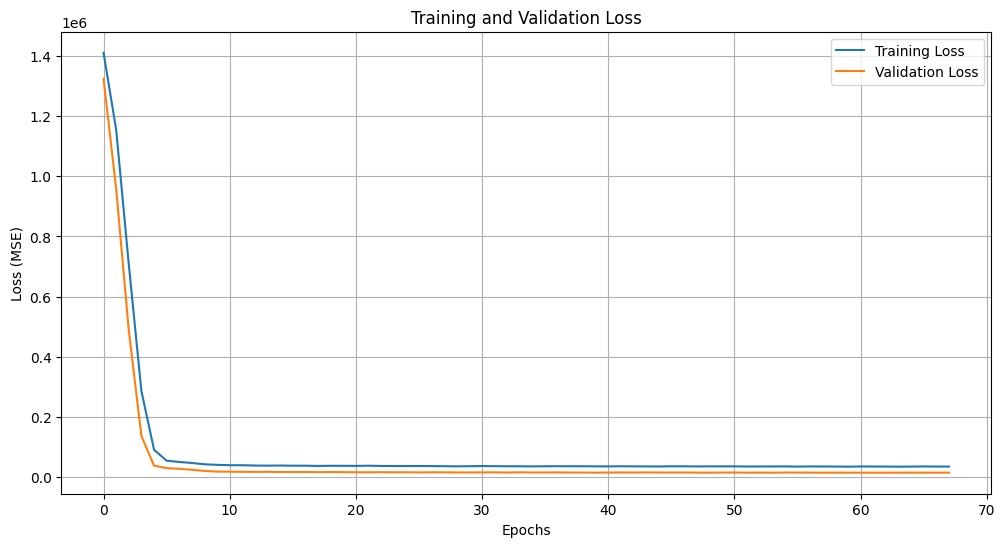

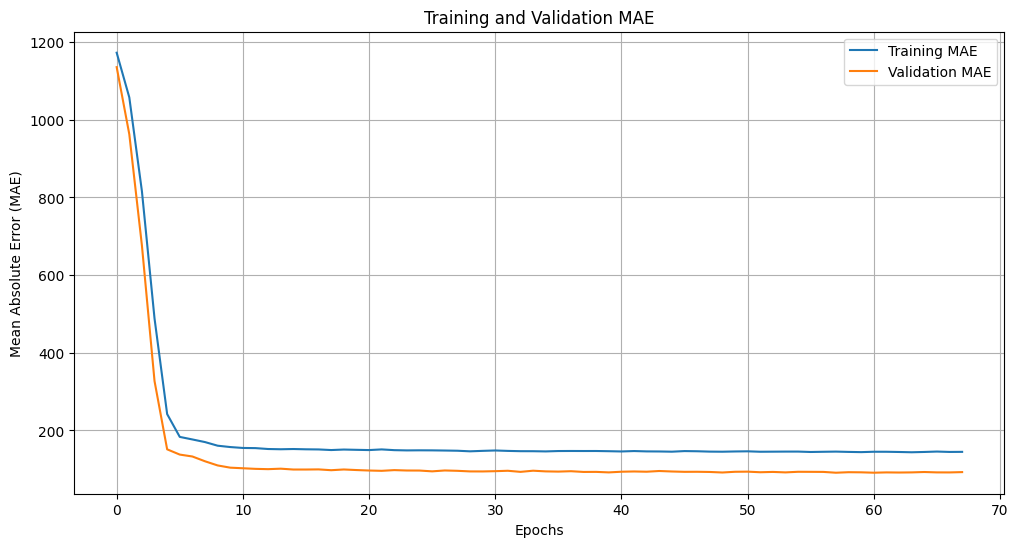

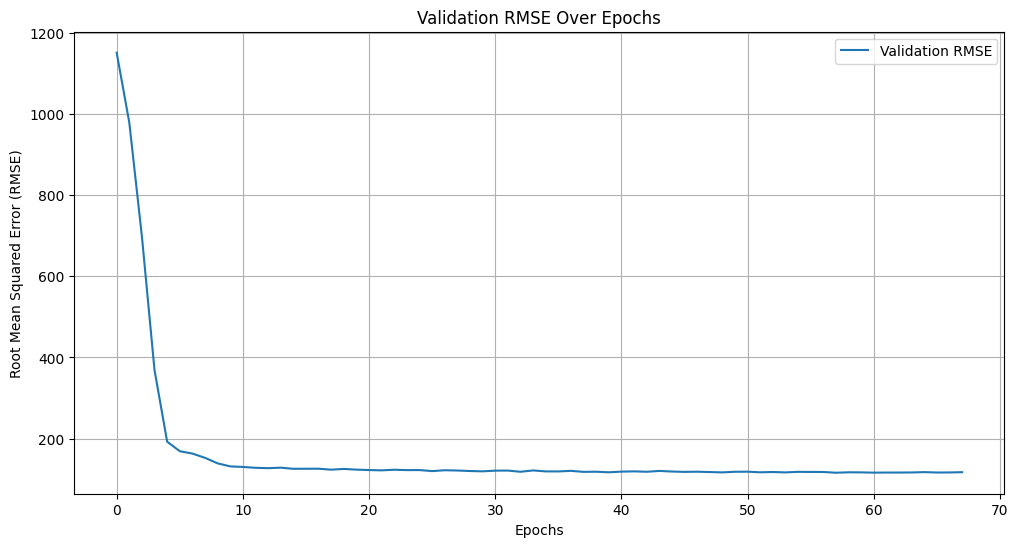

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
import matplotlib.pyplot as plt

# RMSE Callback
class RMSECallback(Callback):
    def __init__(self, validation_data):
        super(RMSECallback, self).__init__()
        self.validation_data = validation_data
        self.layer_rmse = {}

    def on_epoch_end(self, epoch, logs=None):
        # Unpack validation data for prediction
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)

        # Compute RMSE
        rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))

        # Store RMSE for each layer
        for layer in self.model.layers:
            if layer.name not in self.layer_rmse:
                self.layer_rmse[layer.name] = []
            self.layer_rmse[layer.name].append(rmse)

        print(f"Epoch {epoch + 1} - RMSE: {rmse:.4f}")

    def get_layer_rmse(self):
        return self.layer_rmse

# Define model inputs
input_dnn = Input(shape=(X_dnn_train.shape[1],))  # Input for DNN branch
input_lstm = Input(shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]))  # Input for LSTM branch

# DNN branch
dnn = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(input_dnn)
dnn = BatchNormalization()(dnn)
dnn = tf.keras.layers.LeakyReLU(alpha=0.1)(dnn)
dnn = Dropout(0.2)(dnn)
dnn = Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(dnn)
dnn = BatchNormalization()(dnn)
dnn = tf.keras.layers.LeakyReLU(alpha=0.1)(dnn)

# LSTM branch
lstm = LSTM(64, return_sequences=True)(input_lstm)
lstm = Dropout(0.2)(lstm)
lstm = LSTM(32)(lstm)
lstm = Dropout(0.2)(lstm)

# Concatenate DNN and LSTM branches
concat = concatenate([dnn, lstm])

# Fully connected layers after concatenation
fc = Dense(32, activation='relu')(concat)
fc = Dropout(0.2)(fc)
output_layer = Dense(1)(fc)

# Create and compile the model
model = Model(inputs=[input_dnn, input_lstm], outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Instantiate RMSE callback with validation data
rmse_callback = RMSECallback(validation_data=([X_dnn_test, X_lstm_test], y_test))

model_checkpoint = ModelCheckpoint(
    'best_dnn_lstm_model.keras',  # Update the filename extension
    monitor='val_loss',           # Metric to monitor (e.g., 'val_loss')
    save_best_only=True,          # Save only the best model
    mode='min'                    # Minimize 'val_loss' (use 'max' if maximizing metric)
)

# Fit the model
history = model.fit(
    [X_dnn_train, X_lstm_train], y_train,
    validation_data=([X_dnn_test, X_lstm_test], y_test),
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, rmse_callback]
)

# After training, retrieve layer RMSE values
layer_rmse = rmse_callback.get_layer_rmse()

# Plot RMSE for each layer
plt.figure(figsize=(15, len(layer_rmse) * 4))
for i, (layer_name, rmse_values) in enumerate(layer_rmse.items()):
    plt.subplot(len(layer_rmse), 1, i + 1)
    plt.plot(rmse_values, label=f'{layer_name} RMSE')
    plt.title(f'RMSE for Layer: {layer_name}')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model
loss, mae, mse = model.evaluate([X_dnn_test, X_lstm_test], y_test, verbose=1)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

# Save the model
model.save('dnn_lstm_model.keras')

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation RMSE using RMSECallback
val_rmse = [np.sqrt(mse) for mse in history.history['val_mse']]
plt.figure(figsize=(12, 6))
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Validation RMSE Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


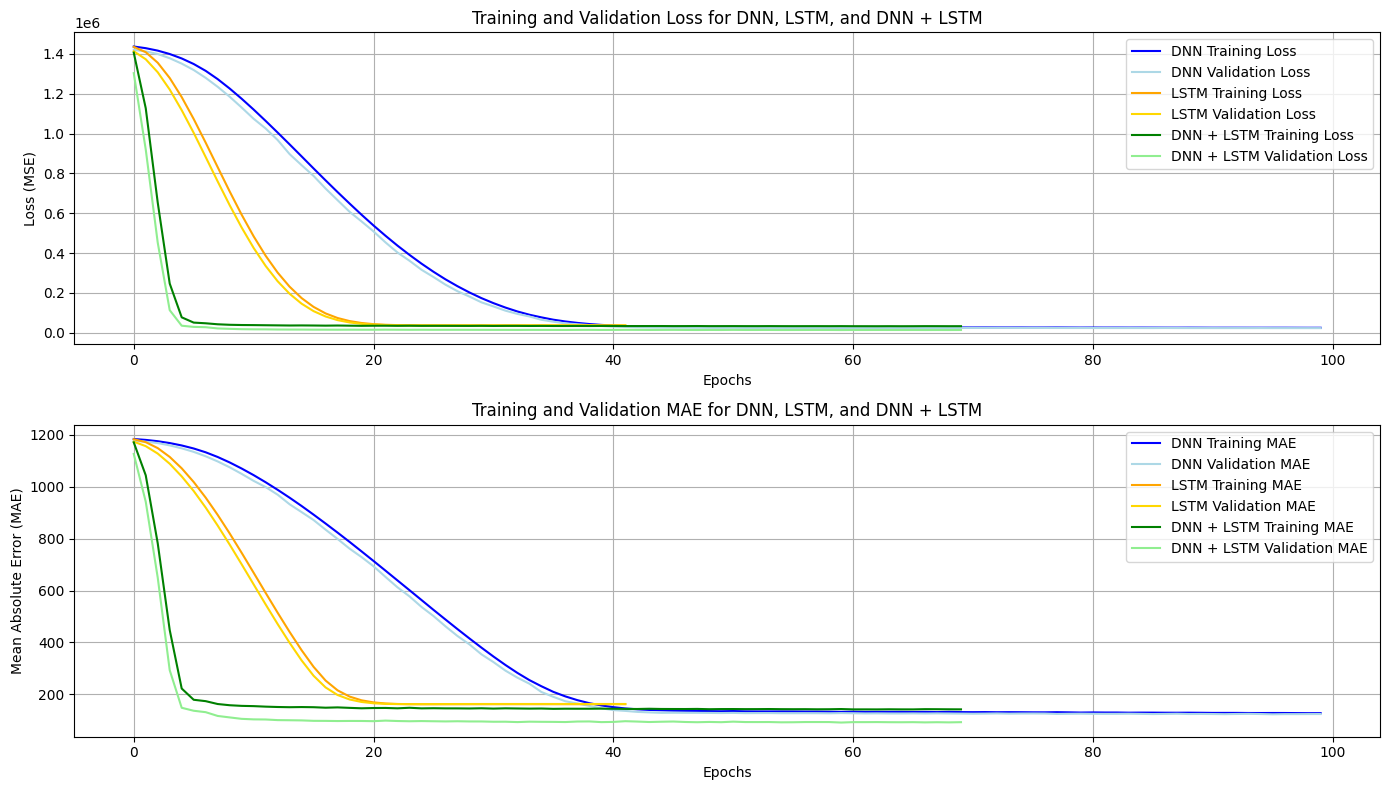

In [16]:
import matplotlib.pyplot as plt

# Prepare data for plotting
dnn_training_loss = history_dnn.history['loss']
dnn_validation_loss = history_dnn.history['val_loss']
dnn_training_mae = history_dnn.history['mae']
dnn_validation_mae = history_dnn.history['val_mae']

lstm_training_loss = history_lstm.history['loss']
lstm_validation_loss = history_lstm.history['val_loss']
lstm_training_mae = history_lstm.history['mae']
lstm_validation_mae = history_lstm.history['val_mae']

dnn_lstm_training_loss = history.history['loss']  # from DNN + LSTM model
dnn_lstm_validation_loss = history.history['val_loss']
dnn_lstm_training_mae = history.history['mae']
dnn_lstm_validation_mae = history.history['val_mae']

# Create a combined plot
plt.figure(figsize=(14, 8))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(dnn_training_loss, label='DNN Training Loss', color='blue')
plt.plot(dnn_validation_loss, label='DNN Validation Loss', color='lightblue')
plt.plot(lstm_training_loss, label='LSTM Training Loss', color='orange')
plt.plot(lstm_validation_loss, label='LSTM Validation Loss', color='gold')  # Changed to 'gold'
plt.plot(dnn_lstm_training_loss, label='DNN + LSTM Training Loss', color='green')
plt.plot(dnn_lstm_validation_loss, label='DNN + LSTM Validation Loss', color='lightgreen')

# Add titles and labels for loss
plt.title('Training and Validation Loss for DNN, LSTM, and DNN + LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot Training and Validation MAE
plt.subplot(2, 1, 2)
plt.plot(dnn_training_mae, label='DNN Training MAE', color='blue')
plt.plot(dnn_validation_mae, label='DNN Validation MAE', color='lightblue')
plt.plot(lstm_training_mae, label='LSTM Training MAE', color='orange')
plt.plot(lstm_validation_mae, label='LSTM Validation MAE', color='gold')  # Changed to 'gold'
plt.plot(dnn_lstm_training_mae, label='DNN + LSTM Training MAE', color='green')
plt.plot(dnn_lstm_validation_mae, label='DNN + LSTM Validation MAE', color='lightgreen')

# Add titles and labels for MAE
plt.title('Training and Validation MAE for DNN, LSTM, and DNN + LSTM')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()


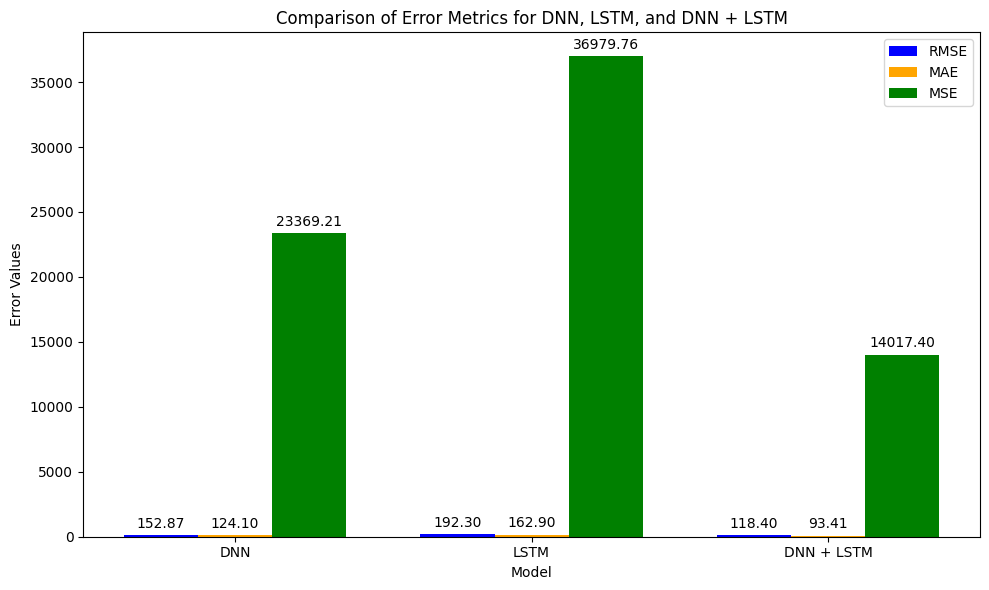

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model
metrics = {
    'DNN': {
        'RMSE': 152.86992147124627,
        'MAE': 124.09563446044922,
        'MSE': 23369.212890625
    },
    'LSTM': {
        'RMSE': 192.30121635730754,
        'MAE': 162.89752197265625,
        'MSE': 36979.7578125
    },
    'DNN + LSTM': {
        'RMSE': 118.39511527217877,
        'MAE': 93.41481018066406,
        'MSE': 14017.4033203125
    }
}

# Prepare data for plotting
labels = list(metrics.keys())
rmse_values = [metrics[label]['RMSE'] for label in labels]
mae_values = [metrics[label]['MAE'] for label in labels]
mse_values = [metrics[label]['MSE'] for label in labels]

# Set up the bar positions
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width, rmse_values, width, label='RMSE', color='blue')
bars2 = ax.bar(x, mae_values, width, label='MAE', color='orange')
bars3 = ax.bar(x + width, mse_values, width, label='MSE', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model')
ax.set_ylabel('Error Values')
ax.set_title('Comparison of Error Metrics for DNN, LSTM, and DNN + LSTM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on the bars
def add_value_labels(bars):
    """Attach a label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# Show the plot
plt.tight_layout()
plt.show()


In [33]:
predictions_lstm_dnn = model.predict([X_dnn_test, X_lstm_test])


451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


In [34]:
predictions_lstm_dnn = predictions_lstm_dnn.reshape(-1)


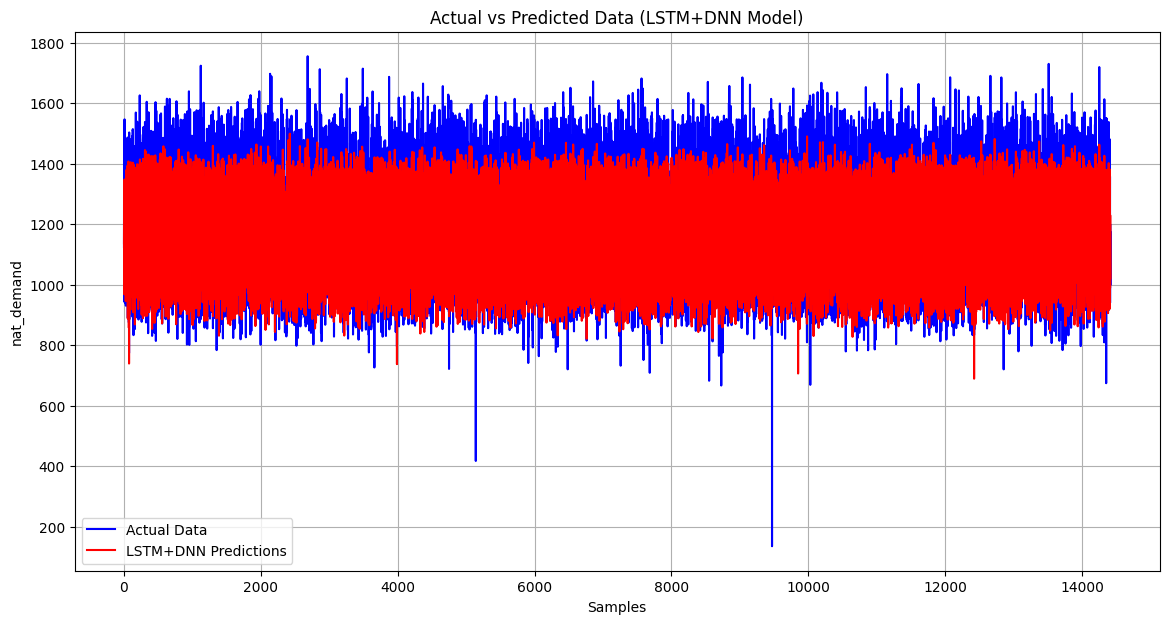

In [37]:


# Plot Actual vs Predicted for LSTM+DNN Model
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Actual Data')
plt.plot(predictions_lstm_dnn, color='red',label='LSTM+DNN Predictions')
plt.title('Actual vs Predicted Data (LSTM+DNN Model)')
plt.xlabel('Samples')
plt.ylabel('nat_demand')
plt.legend()
plt.grid(True)
plt.show()
